# ETL

In [1]:
import os
import pandas as pd
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [2]:
from tqdm import tqdm
from spotipy import Spotify
from pandas import DataFrame

def get_playlist_info(playlist: dict, genre: str):
    return {
        "id": playlist["id"],
        "genre": genre 
    }


def get_track_info(track,genre):
    return {
        "id": track["id"],
        "name": track["name"],
        "album_id": track["album"]["id"],
        "genre":genre
    }


def get_tracks_from_playlists(playlists: DataFrame, sp: Spotify):
    tracks_playlists = []
    errors = []

    for idx, playlist_id in enumerate(tqdm(playlists["id"])):
        try:
            # TODO: get all tracks from playlist
            playlist_tracks = sp.playlist_tracks(playlist_id=playlist_id)
            tracks_playlist = [get_track_info(item["track"],playlists["genre"][idx]) for item in playlist_tracks["items"]]
            tracks_playlists += tracks_playlist
        except TypeError as err:
            # print(f"Error en fila {idx}", err)
            errors.append(f"Error en fila {idx}, {err}")
            continue
    
    print('Errors: ', errors)

    return tracks_playlists

In [3]:
genres_seeds = [  
    "rock","pop","k-pop","hip-hop"
]

In [4]:
# Spotify API credentials
client_id = '5ab3d5c1f176456788d74a39134a4c23'
client_secret = 'ed854e82eb764dc8ac60331cc7afdf65'

In [5]:
# Spotify API authentication
client_credentials_manager = SpotifyClientCredentials(
    client_id=client_id,
    client_secret=client_secret
)
sp = spotipy.Spotify(
    client_credentials_manager=client_credentials_manager
)

In [6]:
playlists = []

for genre in genres_seeds:
    # Search playlists by genre
    playlists_data = sp.search(q=genre, type='playlist', limit=5, offset=0)
    print(len(playlists_data))
    playlists += [
        get_playlist_info(playlist, genre)
        for playlist in playlists_data['playlists']['items']
    ]

df_playlists = pd.DataFrame(playlists)
print(f'Shape playlists', df_playlists.shape)

# Validation of playlists with null values
print(f'Null in id col of playlists', df_playlists["id"].isna().value_counts())

# Delete rows with null values
df_playlists.dropna(inplace=True)
print(f'Null in id col of playlists', df_playlists["id"].isna().value_counts())

df_playlists.head()

1
1
1
1
Shape playlists (20, 2)
Null in id col of playlists False    20
Name: id, dtype: int64
Null in id col of playlists False    20
Name: id, dtype: int64


,id,genre
0,37i9dQZF1EQpj7X7UK8OOF,rock
1,0A2rkMxcYxzYsNRSCdvHyh,rock
2,37i9dQZF1DWXRqgorJj26U,rock
3,2cCaCNdvbqrnIzpsbQc7jF,rock
4,0nlB4rZ5Ng82YoDvOHYqaf,rock


In [7]:
playlists_data = sp.search(q="rock", type='playlist', limit=1, offset=0)

In [15]:
# Get tracks from playlists
tracks_playlists = get_tracks_from_playlists(playlists=df_playlists, sp=sp)
df_tracks = pd.DataFrame(tracks_playlists)
print('Shape tracks:', df_tracks.shape)

# Validation of tracks with null values
print('Null in id col of tracks:', df_tracks["id"].isna().value_counts())

# Delete rows with null values
df_tracks.dropna(inplace=True)
print('Null in id col of tracks:', df_tracks["id"].isna().value_counts())

# Delete duplicates by id
df_tracks.drop_duplicates(subset=["id"], inplace=True)
print('Shape tracks (without duplicates):', df_tracks.shape)

100%|██████████| 20/20 [00:13<00:00,  1.49it/s]

Errors:  ["Error en fila 13, 'NoneType' object is not subscriptable"]
Shape tracks: (1307, 4)
Null in id col of tracks: False    1307
Name: id, dtype: int64
Null in id col of tracks: False    1307
Name: id, dtype: int64
Shape tracks (without duplicates): (1127, 4)


In [9]:
# Save df_tracks to csv
#df_tracks.to_csv('./datasets/tracks.csv', index=False)

OSError: Cannot save file into a non-existent directory: 'datasets'

In [16]:
# Get audio features from tracks
audio_features = []

for n in tqdm(range(len(df_tracks) // 100 + 1)):
    df_track_pack = df_tracks.iloc[n*100:(n+1)*100]
    audio_features_pack = sp.audio_features(tracks=list(df_track_pack['id']))
    audio_features += audio_features_pack

df_audio_features = pd.DataFrame(audio_features)
print('Shape audio features:', df_audio_features.shape)

100%|██████████| 12/12 [00:06<00:00,  1.84it/s]

Shape audio features: (1127, 18)


In [17]:
idx_af_bads = []
for idx, af in enumerate(audio_features):
    if af is None:
        idx_af_bads.append(idx)

print('Number of None values in audio features:', len(idx_af_bads))

Number of None values in audio features: 0


In [18]:
# Delete None values in audio_features before convert to DataFrame
audio_features = [af for af in audio_features if af is not None]
df_audio_features = pd.DataFrame(audio_features)
print('Shape audio features (without None values):', df_audio_features.shape)
df_audio_features.head()

Shape audio features (without None values): (1127, 18)


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.633,0.809,1,-8.595,0,0.0282,0.103000,0.611000,0.0726,0.964,147.916,audio_features,2RBcYkonAofm0rYycVrCGt,spotify:track:2RBcYkonAofm0rYycVrCGt,https://api.spotify.com/v1/tracks/2RBcYkonAofm...,https://api.spotify.com/v1/audio-analysis/2RBc...,224667,4
1,0.390,0.649,2,-5.163,1,0.0345,0.172000,0.000000,0.2160,0.144,121.161,audio_features,5qlJg0Wbj3sslxfwiaRNpq,spotify:track:5qlJg0Wbj3sslxfwiaRNpq,https://api.spotify.com/v1/tracks/5qlJg0Wbj3ss...,https://api.spotify.com/v1/audio-analysis/5qlJ...,299723,4
2,0.640,0.663,0,-7.516,1,0.0374,0.201000,0.008060,0.1520,0.663,132.770,audio_features,4BP3uh0hFLFRb5cjsgLqDh,spotify:track:4BP3uh0hFLFRb5cjsgLqDh,https://api.spotify.com/v1/tracks/4BP3uh0hFLFR...,https://api.spotify.com/v1/audio-analysis/4BP3...,140773,4
3,0.754,0.759,9,-5.218,1,0.3020,0.153000,0.000108,0.1010,0.435,126.366,audio_features,7LRMbd3LEoV5wZJvXT1Lwb,spotify:track:7LRMbd3LEoV5wZJvXT1Lwb,https://api.spotify.com/v1/tracks/7LRMbd3LEoV5...,https://api.spotify.com/v1/audio-analysis/7LRM...,214667,4
4,0.429,0.631,4,-11.514,0,0.0769,0.000078,0.004110,0.1750,0.376,162.734,audio_features,1jzDzZWeSDBg5fhNc3tczV,spotify:track:1jzDzZWeSDBg5fhNc3tczV,https://api.spotify.com/v1/tracks/1jzDzZWeSDBg...,https://api.spotify.com/v1/audio-analysis/1jzD...,168440,4


In [ ]:
# Save df_audio_features to csv
#df_audio_features.to_csv('./datasets/audio_features.csv', index=False)

In [19]:
# Merge dataframes df_tracks and df_audio_features
df_tracks_audio_features = pd.merge(
    df_tracks,
    df_audio_features,
    on="id",
    how="inner"
)
print(f'Shape audio features (after merge with tracks):', df_tracks_audio_features.shape)
df_tracks_audio_features.head()

Shape audio features (after merge with tracks): (1127, 21)


,id,name,album_id,genre,danceability,energy,key,loudness,mode,speechiness,...,instrumentalness,liveness,valence,tempo,type,uri,track_href,analysis_url,duration_ms,time_signature
0,2RBcYkonAofm0rYycVrCGt,Lady Writer,2xQBCPq2gQ7l8thLUUZSKu,rock,0.633,0.809,1,-8.595,0,0.0282,...,0.611000,0.0726,0.964,147.916,audio_features,spotify:track:2RBcYkonAofm0rYycVrCGt,https://api.spotify.com/v1/tracks/2RBcYkonAofm...,https://api.spotify.com/v1/audio-analysis/2RBc...,224667,4
1,5qlJg0Wbj3sslxfwiaRNpq,"I Don't Want To Miss A Thing - From ""Armageddo...",3fk5Yk62Lekng4NQ89980F,rock,0.390,0.649,2,-5.163,1,0.0345,...,0.000000,0.2160,0.144,121.161,audio_features,spotify:track:5qlJg0Wbj3sslxfwiaRNpq,https://api.spotify.com/v1/tracks/5qlJg0Wbj3ss...,https://api.spotify.com/v1/audio-analysis/5qlJ...,299723,4
2,4BP3uh0hFLFRb5cjsgLqDh,Fortunate Son,31q47gQszFt0CddSyMksgO,rock,0.640,0.663,0,-7.516,1,0.0374,...,0.008060,0.1520,0.663,132.770,audio_features,spotify:track:4BP3uh0hFLFRb5cjsgLqDh,https://api.spotify.com/v1/tracks/4BP3uh0hFLFR...,https://api.spotify.com/v1/audio-analysis/4BP3...,140773,4
3,7LRMbd3LEoV5wZJvXT1Lwb,T.N.T.,19AUoKWRAaQYrggVvdQnqq,rock,0.754,0.759,9,-5.218,1,0.3020,...,0.000108,0.1010,0.435,126.366,audio_features,spotify:track:7LRMbd3LEoV5wZJvXT1Lwb,https://api.spotify.com/v1/tracks/7LRMbd3LEoV5...,https://api.spotify.com/v1/audio-analysis/7LRM...,214667,4
4,1jzDzZWeSDBg5fhNc3tczV,Paranoid,132qAo1cDiEJdA3fv4xyNK,rock,0.429,0.631,4,-11.514,0,0.0769,...,0.004110,0.1750,0.376,162.734,audio_features,spotify:track:1jzDzZWeSDBg5fhNc3tczV,https://api.spotify.com/v1/tracks/1jzDzZWeSDBg...,https://api.spotify.com/v1/audio-analysis/1jzD...,168440,4


In [ ]:
# Save df_tracks_audio_features to csv
df_tracks_audio_features.to_csv('./datasets/tracks_audio_features.csv', index=False)

In [20]:
df_tracks_audio_features.columns

Index(['id', 'name', 'album_id', 'genre', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'type', 'uri', 'track_href',
       'analysis_url', 'duration_ms', 'time_signature'],
      dtype='object')

# EDA

In [23]:
#
df_tracks_audio_features.columns

Index(['id', 'name', 'album_id', 'genre', 'danceability', 'energy', 'key',
       'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness',
       'liveness', 'valence', 'tempo', 'type', 'uri', 'track_href',
       'analysis_url', 'duration_ms', 'time_signature'],
      dtype='object')

In [24]:
#Realizamos una exploracion de los datos de df_tracks_audio_features
df_tracks_audio_features.describe()


,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,time_signature
count,1127.000000,1127.000000,1127.000000,1127.000000,1127.000000,1127.000000,1127.000000,1127.000000,1127.000000,1127.000000,1127.000000,1127.000000,1127.000000
mean,0.655679,0.718861,5.247560,-6.089882,0.593611,0.114945,0.141565,0.023600,0.186894,0.556620,122.282106,217417.593611,3.961846
std,0.151123,0.166933,3.629112,2.912027,0.491377,0.106387,0.189217,0.113163,0.146366,0.220021,28.053028,55637.854100,0.275332
min,0.000000,0.001590,0.000000,-27.275000,0.000000,0.000000,0.000018,0.000000,0.022200,0.000000,0.000000,68963.000000,0.000000
25%,0.558000,0.623500,2.000000,-7.506000,0.000000,0.041350,0.012400,0.000000,0.090900,0.397000,99.975500,183193.500000,4.000000
50%,0.667000,0.736000,5.000000,-5.542000,1.000000,0.066600,0.061000,0.000001,0.128000,0.564000,120.040000,210227.000000,4.000000
75%,0.771500,0.848000,8.000000,-4.151000,1.000000,0.154500,0.188500,0.000164,0.252500,0.737000,140.022000,240233.000000,4.000000
max,0.967000,0.996000,11.000000,-0.016000,1.000000,0.741000,0.991000,0.951000,0.946000,0.973000,202.049000,547107.000000,5.000000


In [33]:
df_tracks_audio_features["genre"].value_counts()

pop        312
rock       296
hip-hop    294
k-pop      225
Name: genre, dtype: int64

<Axes: >

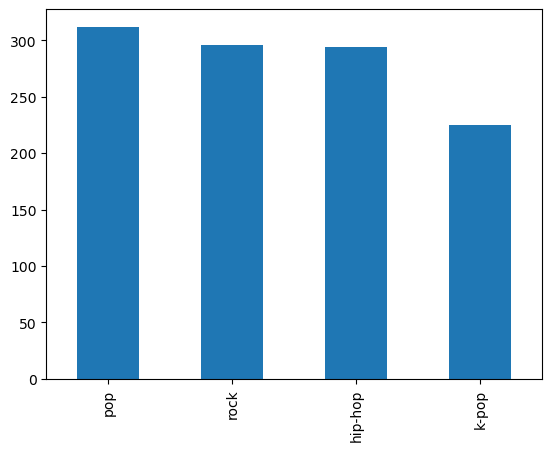

In [34]:
#Realizamos un grafico de barra para ver la distribucion de generos
df_tracks_audio_features["genre"].value_counts().plot(kind="bar")

<Axes: xlabel='genre', ylabel='acousticness'>

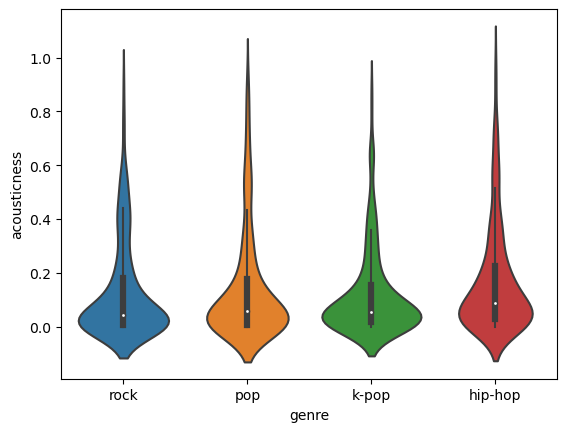

In [51]:
#Realizamos un grafico de violin para la distribucion de las features para cada genero
import seaborn as sns
import matplotlib.pyplot as plt


sns.violinplot(x="genre", y="acousticness", data=df_tracks_audio_features)







In [45]:
sns.violinplot(x="genre", y="danceability", data=df_tracks_audio_features, ax=axes[0,1])


<Axes: xlabel='genre', ylabel='danceability'>

In [46]:
sns.violinplot(x="genre", y="duration_ms", data=df_tracks_audio_features, ax=axes[0,2])


<Axes: xlabel='genre', ylabel='duration_ms'>

In [47]:
sns.violinplot(x="genre", y="energy", data=df_tracks_audio_features, ax=axes[1,0])


<Axes: xlabel='genre', ylabel='energy'>

In [48]:
sns.violinplot(x="genre", y="instrumentalness", data=df_tracks_audio_features, ax=axes[1,1])


<Axes: xlabel='genre', ylabel='instrumentalness'>

In [ ]:
sns.violinplot(x="genre", y="key", data=df_tracks_audio_features, ax=axes[1,2])
sns.violinplot(x="genre", y="liveness", data=df_tracks_audio_features, ax=axes[2,0])
sns.violinplot(x="genre", y="loudness", data=df_tracks_audio_features, ax=axes[2,1])
sns.violinplot(x="genre", y="mode", data=df_tracks_audio_features, ax=axes[2,2])
sns.violinplot(x="genre", y="speechiness", data=df_tracks_audio_features, ax=axes[3,0])
sns.violinplot(x="genre", y="tempo", data=df_tracks_audio_features, ax=axes[3,1])
sns.violinplot(x="genre", y="valence", data=df_tracks_audio_features, ax=axes[3,2])